<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/advance/3D_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install "monai-weekly[nibabel]"
!pip install -U pytorch-lightning
!pip install torchmetrics
!pip install tqdm
%matplotlib inline

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1bb9b938-a494-c086-0265-e01e7a2689a0)


In [4]:
#download data
import os
if os.path.isfile('Task09_Spleen.tar') is False:
  !wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar

In [5]:
import tarfile
if os.path.isdir('Task09_Spleen') is False:
  my_tar = tarfile.open('/content/Task09_Spleen.tar')
  my_tar.extractall('/content/')
  my_tar.close()

In [6]:
from glob import glob
import os
images = sorted(glob("Task09_Spleen/imagesTr/*.nii.gz"))
segs = sorted(glob("Task09_Spleen/labelsTr/*.nii.gz"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
import nibabel as nib
for i in range(len(train_files)):
  img = nib.load(train_files[i]['image'])
  lab = nib.load(train_files[i]['label'])
  print(img.shape,lab.shape)
  break

(512, 512, 55) (512, 512, 55)


In [8]:
import nibabel as nib
val_label_shape=[]
for i in range(len(val_files)):
  img = nib.load(val_files[i]['image'])
  lab = nib.load(val_files[i]['label'])
  val_label_shape.append(lab.shape)
  print(img.shape,lab.shape)
  break

(512, 512, 33) (512, 512, 33)


In [9]:
from  monai import transforms as T
train_transforms = T.Compose(
            [
        T.LoadImaged(keys=["image", "label"]),
        T.AddChanneld(keys=["image", "label"]),
        T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest")),
        T.ScaleIntensityd(keys=["image"]),
        T.ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(384, 384, 128)),
        T.ToTensord(keys=["image", "label"]),
            ]
        )


In [10]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from monai.data import CacheDataset, list_data_collate
from pytorch_lightning.loggers import TensorBoardLogger
from monai.networks.nets import UNet
import torch.nn as nn
import torch
import torchmetrics


In [11]:
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,
                  )

  #parameters
    self.lr=1e-4
    self.bs=1
    self.numworker=1
    self.criterion=DiceLoss(to_onehot_y=True, softmax=True)
    self.metrics = torchmetrics.IoU(num_classes=2)
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=True,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    out=self(image)
    loss=self.criterion(out,segment)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = CacheDataset(data=val_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=False,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    outputs = sliding_window_inference(image, roi_size, sw_batch_size, self.forward)
    loss=self.criterion(outputs,segment)
    iou=self.metrics(outputs.type(torch.float),segment.type(torch.long))
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/iou', iou, on_epoch=True,prog_bar=True)
    return loss


In [12]:
model = OurModel()
logger = TensorBoardLogger("logs", name="my_logs")
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='spleen' )
trainer = Trainer(max_epochs=100, auto_lr_find=False, auto_scale_batch_size=False,
                  #tpu_cores=8,precision=16,
                  gpus=-1,
                  logger=logger,
                  progress_bar_refresh_rate=30,
                  callbacks=[checkpoint_callback]
                  )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | layer     | UNet     | 4.8 M 
1 | criterion | DiceLoss | 0     
2 | metrics   | IoU      | 0     
---------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.236    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:597: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/spleen_state.pt')

# inference

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/spleen_state.pt'))


<All keys matched successfully>

In [ ]:
post_transforms = T.Compose([
        T.Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            meta_keys="pred_meta_dict",  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="img_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
        T.SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="/content/", output_postfix="seg", resample=False),
    ])

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:597: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


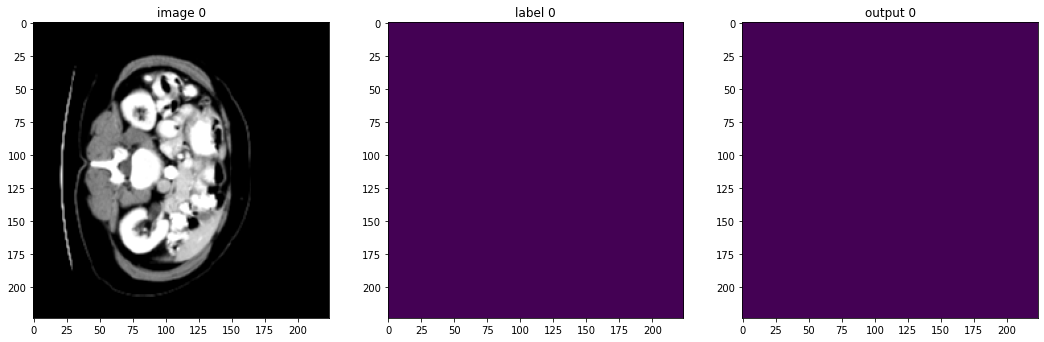


=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-21.00295066833496, 21.715795516967773)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-21.00295066833496, 21.715795516967773)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-21.00295066833496, 21.715795516967773)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-21.00295066833496, 21.715795516967773)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-21.00295066833496, 21.715795516967773)
Data statistics:
Type: <class 'torch.Tensor'>
Sha

RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
model.eval()
device = torch.device("cuda:0")
model.to(device)
val_data=[]
with torch.no_grad():
    for i, val_data in enumerate(model.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data['pred'] = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_data['pred'], dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        post_transforms(val_data["pred"])
        #val_shapes.append(val_data["image"].shape)

In [ ]:
val_data["pred"].shape

torch.Size([1, 2, 224, 224, 192])


=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===

=== Transform input info -- Invertd ===
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-19.865516662597656, 22.062976837158203)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-19.865516662597656, 22.062976837158203)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-19.865516662597656, 22.062976837158203)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-19.865516662597656, 22.062976837158203)
Data statistics:
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 2, 224, 224, 192])
Value range: (-19.865516662597656, 22.062976837158203)


RuntimeError: ignored